# CREATIVE IA

### ENTENDER EL ENUNCIADO DEL PROBLEMA Y EL CASO PRACTICO

### IA CREATIVA
* La IA Creativa es una nueva rama de la inteligencia artifical que puede crear retratos, escribir historias alucinantes o componer musica.

### QUE ES EL SUEÑO PROFUNDO?
* El deep dream es el algoritmo de IA mas extraño y espeluznante hasta la fecha
* Deep dream es un algoritmo de Computer Vision desarrollado por Alex Mordvinstend de Google
* El algoritmo funciona como creando un efecto de sueño
* Es como darle a los humanos una droga extremadamente poderosa! A medida que la imagen se envia cada vez mas a la red, comenzaran a aparecer caracteristicas mas extrañas
* Recuerdas cuando eras un niño mirando las nubes y tratando de interpretar formas? Estos es un caballo, un perro... Bueno deep dream hace lo mismo al aumentar los patrones que ve en una imagen determinada en funcion de lo que ha sido entrenado para ver en el pasado (durante el entrenamiento)
* Si una red ha sido entrenada para ver animales en imagenes, intentara extraer caracteristicas de animales en cualquier imagen dada

### LIBRERIAS

In [2]:
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as display
import random 
import os
import PIL.Image
import cv2
from PIL import Image # Python Image Library es una librería que añade soporte 
                      # para abrir, manipular
                      # y guardar diferentes formatos de imágenes

In [3]:
np.__version__

'1.21.6'

In [4]:
tf.__version__

'2.8.0'

### CARGAMOS EL MODELO INCEPTIONV3

In [5]:
path_data = "../dataset/CreativeIA/"

In [6]:
# Cargamos el modelo Inception entrenado
base_model = tf.keras.applications.InceptionV3(
    include_top = False,
    weights = 'imagenet'
)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-08-21 16:14:14.044417: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-21 16:14:14.044525: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### TAREA 1 
* Cuantos parametros totales existen en InceptionV3?

Tiene 21,802,784 parametros

In [7]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                    

### DATASET

In [8]:
# Abrir la primera imagen
img_1 = Image.open(path_data + 'mars.jpg')

# Abrir la segunda image
img_2 = Image.open(path_data + 'eiffel.jpg')

# Fusionar ambas imagen
image = Image.blend(img_1, img_2, 0.5) # alpha --> el factor alfa de interpolacion. si alfa es 0, se devuelve una copia de la primer imagen
# si alpha es 1, se devuelve una copia de la segunda imagen

# Guardamos la imagen mezclada
image.save(path_data + "img_0.jpg")  

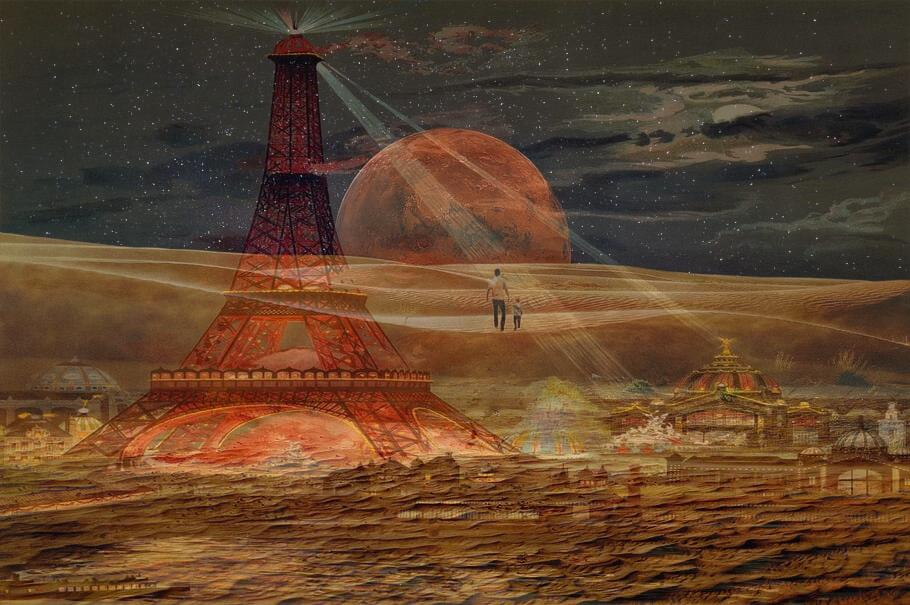

In [9]:
# Cargamos la imagen
Sample_Image = tf.keras.preprocessing.image.load_img(path_data + 'img_0.jpg')
Sample_Image

In [10]:
# Obtenemos el tamaño de la imagen
np.shape(Sample_Image)

(605, 910, 3)

In [11]:
type(Sample_Image)

PIL.JpegImagePlugin.JpegImageFile

In [12]:
# Convertimos a array de numpy
Sample_Image = tf.keras.preprocessing.image.img_to_array(Sample_Image)

# Confirmamos que la imagen se convierte en una matriz de numpy
type(Sample_Image)

numpy.ndarray

In [13]:
# Obtenemos los valores minimos y maximos
print('Minimo valor de pixel = {}, Maximo valor de pixel = {}'.format(Sample_Image.min(), Sample_Image.max()))

# Normalizar la imagen de entrada
Sample_Image = np.array(Sample_Image) / 255.0
Sample_Image.shape

Minimo valor de pixel = 0.0, Maximo valor de pixel = 255.0


(605, 910, 3)

In [14]:
# Verificamos los valores normalizados
print('Minimo valor de pixel = {}, Maximo valor de pixel = {}'.format(Sample_Image.min(), Sample_Image.max()))
Sample_Image.shape

Minimo valor de pixel = 0.0, Maximo valor de pixel = 1.0


(605, 910, 3)

In [15]:
Sample_Image = tf.expand_dims(Sample_Image, axis = 0)
np.shape(Sample_Image)

TensorShape([1, 605, 910, 3])

### TAREA 2
* Realizar lo opuesto a expandir dimension
* Representar la imagen

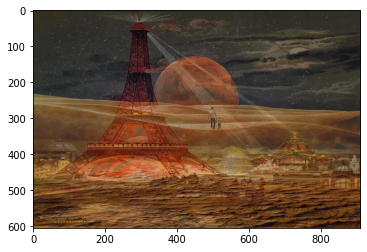

In [33]:
plt.imshow(np.squeeze(Sample_Image))

In [35]:
print(np.shape(np.squeeze(Sample_Image)))

(605, 910, 3)


### EJECUTAR EL MODELO PREENTRENADO Y EXPLORAR LAS ACTIVACIONES

#### NOTAS 
- Seleccionamos una capa e intentamos maximizar la pérdida que son las activaciones generadas por la capa de interés.
- Podemos seleccionar cualquier capa que elijamos, las primeras capas generan características simples como bordes y las capas profundas generan características más complejas como cara completa, carro o árbol.
- La red de inicio tiene múltiples capas concatenadas llamadas 'mixtas'

In [16]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                    

In [17]:
# Vamos a maximizar la activacion de estas capas
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Creamos el modelo de extraccion de caracteristicas
deepDream_model = tf.keras.Model(
    inputs = base_model.input, 
    outputs = layers
)

deepDream_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [17]:
# Ejecutamos el modelo suministrando la imagen de entrada y 
# echando un ojo a las activaciones de las neuronas de salida
activations = deepDream_model(Sample_Image)
activations

[<tf.Tensor: shape=(1, 36, 55, 768), dtype=float32, numpy=
 array([[[[0.        , 0.        , 0.        , ..., 0.        ,
           0.28813428, 0.30937186],
          [0.        , 0.33028   , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.16165644, 0.        , ..., 0.        ,
           0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.3707034 ,
           0.        , 0.        ],
          [0.03586781, 0.        , 0.        , ..., 0.3707034 ,
           0.64610547, 0.        ]],
 
         [[0.7529496 , 0.        , 0.        , ..., 0.        ,
           0.16688907, 0.7020421 ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.30318758],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          ...,
        

In [18]:
len(activations)

2

### TAREA 3
* Genera las activaciones para una capa mas profunda como mixed8 y mixed9
* Cual es el tamaño de las activaciones generadas?
* Combina 4 activaciones de capas de inicio y mas profundas como mixed3, mixed5, mixed8 y mixed9

In [19]:
# RESOLUCION TAREA 3
# Vamos a maximizar la activacion de estas capas
#names = ['mixed3', 'mixed5', 'mixed7']
names = ['mixed3', 'mixed5', 'mixed8', 'mixed9']
layers = [base_model.get_layer(name).output for name in names]

# Creamos el modelo de extraccion de caracteristicas
deepDream_model = tf.keras.Model(
    inputs = base_model.input, 
    outputs = layers
)

deepDream_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                         

In [20]:
# Ejecutamos el modelo suministrando la imagen de entrada y 
# echando un ojo a las activaciones de las neuronas de salida
activations = deepDream_model(Sample_Image)
activations

[<tf.Tensor: shape=(1, 36, 55, 768), dtype=float32, numpy=
 array([[[[0.        , 0.        , 0.        , ..., 0.        ,
           0.28813428, 0.30937186],
          [0.        , 0.33028   , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.16165644, 0.        , ..., 0.        ,
           0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.3707034 ,
           0.        , 0.        ],
          [0.03586781, 0.        , 0.        , ..., 0.3707034 ,
           0.64610547, 0.        ]],
 
         [[0.7529496 , 0.        , 0.        , ..., 0.        ,
           0.16688907, 0.7020421 ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.30318758],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          ...,
        

### COMPRENDER COMO FUNCIONA EL ALGORITMO DE DEEP DREAM

#### COMO FUNCIONA EL ALGORITMO DE SUEÑO PROFUNDO?
* Si envias una imagen a una RNC, las primeras capas generalmente detectan caracteristicas de bajo nivel como los bordes
* A medida que se avanza en la red, se detectan caracteristicas de nivel superior, como caras, arboles y automoviles
* Las ultimas capas las reunen en interpretaciones completas: estas neuronas se activan en respuesta a cosas muy complejas como edificios o arboles enteros, explican los ingenieros de Google
* Que pasa si le pides a una determinada capa que mejore lo que se detecta en una imagen?
* Que pasa si le preguntas al primer par de capas que son expertas en detectar bordes para maximizar lo que ven?
* Que pasa si le preguntas al ultimo par de capas (las mas profundas) que son expertos en la deteccion de elementos (caracteristicas de nivel superior como autos, caras) para aumentar lo que realmente ven?
* Las cosas se ponen realmente como si fueran sueños increibles! Eso es lo que llamo Google como `INCEPTIONISMO`

* Cuando suministramos una imagen a una RNA entrenada, las neuronas se dispersan y generan activaciones
* El algoritmo del deep dream funciona al intentar cambiar la imagen de entrada de una manera que haga que algunas de estas neuronas se disparen mas (aumenten el disparo o las activaciones de las neuronas). Puedes seleccionar que neuronas en que capa estas interesado para que se activen de manera mas prominente
* El proceso se repite continuamente hasta que la imagen de entrada ahora contiene todas las caracteristicas que una capa especifica estaba buscando originalmente
    * Ejemplo: si una determinada capa era experta en reconocer caras de perros y intentamos suministrar una imagen de un cielo azul, el algoritmo de deep dream cambiara continuamente la imagen de entrada y comenzara a crear imagenes de caras de perros en la parte superior del cielo azul. El proceso se repite hasta que la capa de interes esta contenta con los resultados!

#### PASOS DEL ALGORITMO DE DEEP DREAM
* PASOS:
    * 1 - Se envia una imagen a traves de una RNA, RNC, ResNet entrenada
    * 2 - Se selecciona una capa de tu eleccion (las primeras capas capturan bordes, las capas profundas capturan formas completas como caras)
    * 3 - Se calculan las activaciones (salida) que salen de la capa de interes
    * 4 - Se calcula el gradiente de las activaciones con respecto a la imagen de entrada
    * 5 - Se modifica la imagen para aumentar estas activaciones y, por lo tanto mejorar los patrones vistos por la red, lo que da como resultado una imagen alucinada muy trippy
    * 6 - Se itera y repite en varias escalas



### COMPRENDER COMO REALIZAR EL CALCULO DE GRADIENTES Y TF.GRADIENTAPE()

- tf.GradientTape () se usa para registrar operaciones para diferenciación automática
- Por ejemplo, supongamos que tenemos las siguientes funciones $y = x^3$.
- El gradiente en $x = 2$ se puede calcular de la siguiente manera: $\frac{dy}{dx} = 3 \cdot x ^ 2 = 3 \cdot 2 ^ 2 = 12$.

In [18]:
x = tf.constant(2.0)

with tf.GradientTape() as g:
    g.watch(x)
    y = x * x * x
dy_dx = g.gradient(y, x) # Nos va a dar 12

dy_dx

<tf.Tensor: shape=(), dtype=float32, numpy=12.0>

### TAREA 4
- Usando tf.GradientTape (), calcula el gradiente de $y = x ^ 4 + x ^ 5$ en $x = 5$
- Verifica la respuesta diferenciando manualmente la ecuación

In [19]:
x = tf.constant(5.0)

with tf.GradientTape() as g:
    g.watch(x)
    y = (x * x * x * x) + (x * x * x * x * x)
dy_dx = g.gradient(y, x) # Nos va a dar 

dy_dx

<tf.Tensor: shape=(), dtype=float32, numpy=3625.0>

# IMPLEMENTAR EL ALGORITMO DEL DEEP DREAM

### PASO 1 - CALCULO DE PERDIDAS

In [20]:
# Dado que la funcion cal_closs incluye expandir dimension, aplanamos primero la imagen (reduce dims)
Sample_Image.shape

TensorShape([1, 605, 910, 3])

In [21]:
Sample_Image = tf.squeeze(Sample_Image, axis = 0)
Sample_Image.shape

TensorShape([605, 910, 3])

In [23]:
Sample_Image = tf.Variable(Sample_Image)
type(Sample_Image)

tensorflow.python.ops.resource_variable_ops.ResourceVariable

In [24]:
loss = calc_loss(tf.Variable(Sample_Image), deepDream_model)

ACTIVATION VALUES (LAYER OUTPUT) =
 [<tf.Tensor: shape=(1, 36, 55, 768), dtype=float32, numpy=
array([[[[0.        , 0.        , 0.        , ..., 0.        ,
          0.28813428, 0.30937186],
         [0.        , 0.33028   , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.16165644, 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.3707034 ,
          0.        , 0.        ],
         [0.03586781, 0.        , 0.        , ..., 0.3707034 ,
          0.64610547, 0.        ]],

        [[0.7529496 , 0.        , 0.        , ..., 0.        ,
          0.16688907, 0.7020421 ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.30318758],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
       

In [26]:
loss

<tf.Tensor: shape=(), dtype=float32, numpy=0.5186523>

# IMPLEMENTAR EL ALGORITMO DEL DEEP DREAM

### PASO 2 - CALCULO DE GRADIENTE

- En este paso, nos basaremos en la pérdida que se ha calculado en el paso anterior y calcularemos el gradiente con respecto a la imagen de entrada dada y luego lo agregaremos a la imagen original de entrada.
- ¡Hacerlo de forma iterativa dará como resultado imágenes de alimentación que excitan de manera continua y creciente a las neuronas y generan más imágenes de ensueño!

In [25]:
def deprocess(image):
    image = 255*(image + 1.0)/2.0
    return tf.cast(image, tf.uint8)

In [28]:
Sample_Image.shape

TensorShape([605, 910, 3])

In [34]:
def calc_loss(img, model):
    # Funcion utilizada para el calculo de perdidas
    # Funciona transmitiendo la imagen de entrada a traves de la red y generando activaciones
    # Luego se obtiene el promedio y la suma de esas salidas
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)
    if len(layer_activations) == 1:
        layer_activations = [layer_activations]

    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)

    return  tf.reduce_sum(losses)

In [26]:
class DeepDream(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(
        input_signature=(
            tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
            tf.TensorSpec(shape=[], dtype=tf.int32),
            tf.TensorSpec(shape=[], dtype=tf.float32),)
    )
    def __call__(self, img, steps, step_size):
        print("Tracing")
        loss = tf.constant(0.0)
        for n in tf.range(steps):
            with tf.GradientTape() as tape:
                # Se necesitan gradientes con respecto a 'img'
                # 'GradientTape' solo permite watch de 'tf.Variable' por defecto
                tape.watch(img)
                loss = calc_loss(img, self.model)

            # Calculamos el gradiente de la perdida con respecto a los pixeles de la imagen de entrada
            # La sintaxis es la siguiente: dy_dx = g.gradietn(y, x)
            gradients = tape.gradient(loss, img)

            # Normalizar el gradiente
            # tf.math.reduce_std calcula la desviacion estandar de elementos en las dimensiones de un tensor
            gradients /= tf.math.reduce_std(gradients) + 1e-8 
            
            # En el gradiente ascendente, la "perdida" se maimiza de modelo que la imagen
            # de entrada "excita" cada vez mas las capas
            # Puede actualizar la imagen agregando directamente los gradientes (tiene la misma forma)
            img = img + gradients*step_size
            img = tf.clip_by_value(img, -1, 1)

        return loss, img

In [27]:
deepdream = DeepDream(deepDream_model)
deepdream

In [28]:
# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))

In [39]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
    # Se convierte de uint8 al rango esperado por el modelo
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = tf.convert_to_tensor(img)
    step_size = tf.convert_to_tensor(step_size)
    steps_remaining = steps
    step = 0
    while steps_remaining:
        if steps_remaining>100:
            run_steps = tf.constant(100)
        else:
            run_steps = tf.constant(steps_remaining)
        steps_remaining -= run_steps
        step += run_steps

        loss, img = deepdream(img, run_steps, tf.constant(step_size))
        
        #display.clear_output(wait=True)
        show(deprocess(img))
        print ("Step {}, loss {}".format(step, loss))


    result = deprocess(img)
    display.clear_output(wait=True)
    show(result)

    return result

In [30]:
type(Sample_Image)

tensorflow.python.ops.resource_variable_ops.ResourceVariable

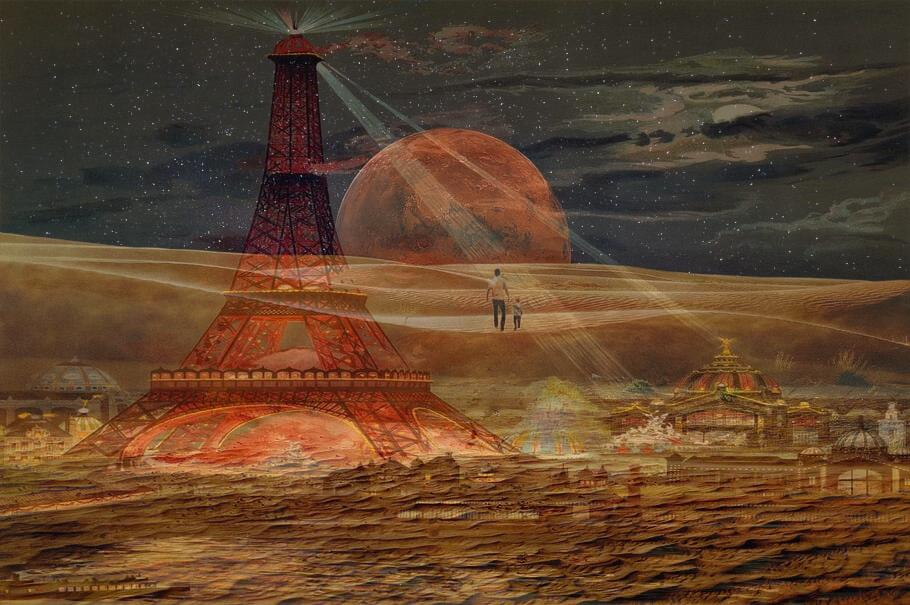

In [42]:
Sample_Image = tf.keras.preprocessing.image.load_img(path_data + 'img_0.jpg')
Sample_Image

In [43]:
Sample_Image = np.array(Sample_Image)
type(Sample_Image)

numpy.ndarray

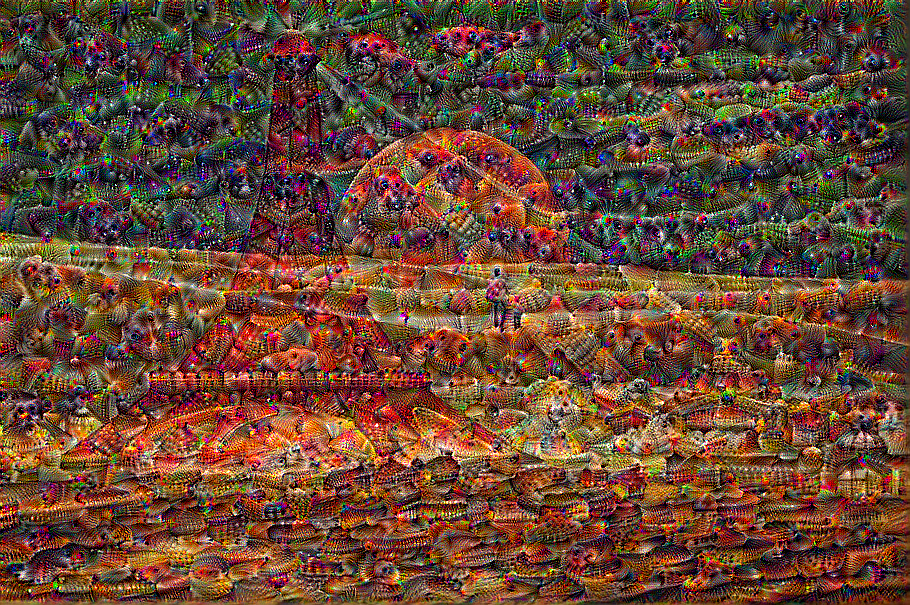

In [44]:
dream_img = run_deep_dream_simple(img = Sample_Image, steps = 4000, step_size = 0.001)

In [45]:
dream_img

<tf.Tensor: shape=(605, 910, 3), dtype=uint8, numpy=
array([[[ 74,  63,  58],
        [ 73,  37,  35],
        [126,  40,   0],
        ...,
        [ 60,  52,  37],
        [ 59,  51,  38],
        [ 55,  53,  41]],

       [[ 80,  72,  54],
        [ 38,   0,  23],
        [102,  36,   0],
        ...,
        [ 61,  52,  33],
        [ 59,  51,  35],
        [ 55,  53,  41]],

       [[ 91,  21,  25],
        [ 31,   0,  15],
        [ 69,   0,   0],
        ...,
        [ 60,  45,  29],
        [ 58,  52,  36],
        [ 53,  51,  39]],

       ...,

       [[140,  97,  44],
        [148,  99,  45],
        [153, 120,  43],
        ...,
        [108,  53,  28],
        [105,  52,  22],
        [102,  50,  19]],

       [[128,  83,  32],
        [137,  91,  38],
        [142,  94,  42],
        ...,
        [101,  46,  21],
        [ 98,  44,  17],
        [ 95,  45,  13]],

       [[130,  90,  37],
        [140,  99,  45],
        [143, 103,  50],
        ...,
        [ 91,  41,  1